<a href="https://colab.research.google.com/github/milosevska0/data-science-project/blob/main/Intro_to_Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

!pip install fuzzywuzzy[speedup]
from fuzzywuzzy import process

from google.colab import files

from sklearn.preprocessing import MinMaxScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.0 MB/s eta 0:00:00


# Downloading all the datasets from google drive using gdown

In [2]:
!gdown 1dPe0XFeqPVp3ZUsnqvlJF25HuMik1H-y
!gdown 1Ca2PcVxatAp5leB70Zcd60VRa7ySBPHS
!gdown 1cqy6VD62FhNL-8e7ocOEQtO9j6QmhAQF
!gdown 1btapbYj_XEOgcyZWvrUX5QSmY0FuYd6o
!gdown 1MDC8zNfOCWMgiNl13dHapceYalNKhkoV
!gdown 1rXpGB5GMSDtK6Q7740xSk6KWWVgkJWFA
!gdown 1p5VQGtnZ5nDJhQmaAlz84OCYGOrQhMML
!gdown 1OtQcOH7wDsBNPrzQVGCEe1sIfD5B7rUa

Downloading...
From: https://drive.google.com/uc?id=1dPe0XFeqPVp3ZUsnqvlJF25HuMik1H-y
To: /content/CHEP_of_GDP.csv
100% 83.8k/83.8k [00:00<00:00, 56.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ca2PcVxatAp5leB70Zcd60VRa7ySBPHS
To: /content/CHE_per_capita.csv
100% 89.5k/89.5k [00:00<00:00, 20.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cqy6VD62FhNL-8e7ocOEQtO9j6QmhAQF
To: /content/Life_expectancy.csv
100% 164k/164k [00:00<00:00, 20.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1btapbYj_XEOgcyZWvrUX5QSmY0FuYd6o
To: /content/GDP_percent.xls
100% 55.5k/55.5k [00:00<00:00, 8.12MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MDC8zNfOCWMgiNl13dHapceYalNKhkoV
To: /content/Inflation_percent.xls
100% 53.3k/53.3k [00:00<00:00, 50.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rXpGB5GMSDtK6Q7740xSk6KWWVgkJWFA
To: /content/GDP_percent.csv
100% 27.4k/27.4k [00:00<00:00, 53.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1

# Loading the data into dataframes

In [3]:
# World Bank
CHEP_of_GDP = pd.read_csv('/content/CHEP_of_GDP.csv') # Current Health Expanditure (% of GDP)
CHE_per_capita = pd.read_csv('/content/CHE_per_capita.csv') # Current Health Expanditure per capita
life_expectancy = pd.read_csv('/content/Life_expectancy.csv') # Life expectancy

# IMF
GDP_percent = pd.read_csv('/content/GDP_percent.csv', encoding='latin1') #  Gross Domestic Product, constant prices (PERCENT CHANGE)
inflation_percent = pd.read_csv('/content/Inflation_percent.csv', encoding='latin1') # Inflation, average consumer prices (PERCENT CHANGE)

# WHO
hospital_beds = pd.read_csv('/content/Hospital_beds.csv') # Hospital beds per 10000 population

# Preprocessing the hospital_beds dataset only, since it is different


In [4]:
columns_to_keep = ['Location', 'Period', 'Value']
hospital_beds = hospital_beds[columns_to_keep]
hospital_beds_pivot = hospital_beds.groupby(['Location', 'Period']).mean().reset_index()
hospital_beds_pivot = hospital_beds_pivot.pivot(index='Location', columns='Period', values='Value')

hospital_beds_pivot.columns.name = None
hospital_beds_pivot = hospital_beds_pivot.reset_index()

columns_to_keep = ['Location'] + [year for year in range(2011, 2022)]
columns_to_keep = [col for col in columns_to_keep if col in hospital_beds_pivot.columns]
hospital_beds_pivot = hospital_beds_pivot[columns_to_keep]

hospital_beds = hospital_beds_pivot

# converting the numerical column headers into strings
new_columns = {col: str(col) if isinstance(col, int) else col for col in hospital_beds.columns}

hospital_beds = hospital_beds.rename(columns=new_columns)

# Preprocessing all datasets


In [5]:
def process_dataset(df):
  # transforming the columns

  if 'Country Name' in df.columns:
    df = df.rename(columns={'Country Name': 'Country'})
  elif 'Location' in df.columns:
    df = df.rename(columns={'Location': 'Country'})

  columns_to_keep = ['Country'] +[str(year) for year in range(2011, 2022)]
  df = df[columns_to_keep]

  # handling missing values
  missing_values_per_country = df.iloc[:, 1:].isnull().sum(axis=1)
  countries_to_keep = missing_values_per_country[missing_values_per_country <=3].index
  df = pd.DataFrame(df.loc[countries_to_keep])

  numerical_columns = df.columns[1:]
  df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')
  df_interpolated = df[numerical_columns].interpolate(method='linear', axis=1)

  df_filled = df_interpolated.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
  df_filled.insert(0, 'Country', df['Country'])

  return df_filled


datasets = [CHEP_of_GDP, CHE_per_capita, life_expectancy, GDP_percent, inflation_percent, hospital_beds]
processed_datasets = {}
datasets_dict = {
    "Current Health Expanditure (% of GDP)": CHEP_of_GDP,
    "Current Health Expanditure per capita": CHE_per_capita,
    "Life expectancy": life_expectancy,
    "Gross Domestic Product (percent change)": GDP_percent,
    "Inflation (percent change)": inflation_percent,
    "Hospital beds per 10000 population": hospital_beds
}
for name, dataset in datasets_dict.items():
  processed_df = process_dataset(dataset)
  if processed_df is not None:
    processed_datasets[name] = processed_df


# Displaying the final version of the processed datasets

In [6]:

dataset_index = 1

for name, dataset in processed_datasets.items():

    print(f"------------------------------------------------------------------------------------------------------")
    print(f"{dataset_index}. {name} DataFrame")
    display(dataset.head())
    print()

    if dataset.isnull().sum().sum() == 0:
        print("The dataset doesn't have null values.")
    else:
        print("Null values were found in the dataset.")
    print()

    dataset_index += 1

------------------------------------------------------------------------------------------------------
1. Current Health Expanditure (% of GDP) DataFrame


,Country,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,Africa Eastern and Southern,6.354503,6.168263,6.179716,5.840838,5.998180,6.097986,5.953892,5.809334,5.830223,5.881779,5.865553
2,Afghanistan,8.561908,7.897169,8.805964,9.528878,10.105348,11.818590,12.620817,14.208419,14.831320,15.533614,21.827950
3,Africa Western and Central,3.523384,3.489340,3.603168,3.583835,3.806468,3.796931,3.817355,3.430338,3.417184,3.840715,4.140713
4,Angola,2.645608,2.395750,2.732827,2.434129,2.605795,2.713150,2.793838,2.588796,2.475180,3.220706,2.960106
5,Albania,6.182977,6.157462,6.282863,6.434511,6.464119,6.729327,6.578488,6.668446,6.862141,7.519203,7.267318



The dataset doesn't have null values.

------------------------------------------------------------------------------------------------------
2. Current Health Expanditure per capita DataFrame


,Country,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,Africa Eastern and Southern,113.689714,110.501014,108.335145,101.823439,93.774848,88.744566,92.932863,92.964251,89.944546,81.492418,92.286386
2,Afghanistan,52.363049,52.613541,56.305542,60.189579,60.058540,61.486458,66.909218,71.334305,74.234108,80.288055,81.319763
3,Africa Western and Central,67.174846,69.609618,77.142250,80.027055,71.692629,62.506163,60.649525,59.443774,61.866884,64.646044,72.959639
4,Angola,121.913689,121.795754,142.886169,130.742340,107.643562,94.106155,112.851471,83.899200,64.657791,55.051022,64.163422
5,Albania,274.776886,262.288544,278.042511,295.123596,255.356354,277.043213,297.461975,351.301208,367.758392,396.880249,464.742859



The dataset doesn't have null values.

------------------------------------------------------------------------------------------------------
3. Life expectancy DataFrame


,Country,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,75.465000,75.531000,75.636000,75.601000,75.683000,75.617000,75.903000,76.072000,76.248000,75.723000,74.626000
1,Africa Eastern and Southern,59.293271,60.050780,60.709870,61.337917,61.856458,62.444050,62.922390,63.365863,63.755678,63.313860,62.454590
2,Afghanistan,61.419000,61.923000,62.417000,62.545000,62.659000,63.136000,63.016000,63.081000,63.565000,62.575000,61.982000
3,Africa Western and Central,55.013138,55.340561,55.673406,55.922229,56.195872,56.581678,56.888446,57.189139,57.555796,57.226373,56.988657
4,Angola,57.596000,58.623000,59.307000,60.040000,60.655000,61.092000,61.680000,62.144000,62.448000,62.261000,61.643000



The dataset doesn't have null values.

------------------------------------------------------------------------------------------------------
4. Gross Domestic Product (percent change) DataFrame


,Country,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,6.479,13.968,5.683,2.697,0.988,2.164,2.647,1.189,3.912,-5.000,4.000
1,Albania,2.545,1.418,1.002,1.774,2.219,3.315,3.802,4.071,2.240,-3.500,5.000
2,Algeria,2.900,3.400,2.800,3.800,3.700,3.200,1.300,1.200,0.800,-5.992,2.864
3,Angola,3.472,8.542,4.955,4.823,0.944,-2.580,-0.150,-2.000,-0.600,-3.975,0.373
4,Antigua and Barbuda,-1.959,3.372,-0.601,3.797,3.824,5.498,3.144,6.950,3.351,-17.273,-2.987



The dataset doesn't have null values.

------------------------------------------------------------------------------------------------------
5. Inflation (percent change) DataFrame


,Country,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,11.804,6.441,7.386,4.674,-0.662,4.384,4.976,0.626,2.302,5.607,5.062
1,Albania,3.443,2.036,1.925,1.613,1.868,1.287,1.986,2.008,1.438,1.603,1.956
2,Algeria,4.500,8.916,3.255,2.917,4.784,6.398,5.591,4.270,1.952,2.415,4.935
3,Angola,13.484,10.285,8.782,7.298,9.159,30.694,29.844,19.629,17.079,22.277,22.295
4,Antigua and Barbuda,3.457,3.377,1.059,1.089,0.969,-0.489,2.432,1.211,1.431,1.058,2.045



The dataset doesn't have null values.

------------------------------------------------------------------------------------------------------
6. Hospital beds per 10000 population DataFrame


,Country,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,4.5,4.7,4.6,4.6,4.4,4.5,4.2,4.0,3.8,3.4,3.6
1,Albania,28.9,28.9,29.0,28.8,28.5,28.4,28.4,28.4,28.5,29.1,29.1
6,Argentina,44.1,46.0,48.0,48.6,49.7,49.7,50.2,37.1,37.1,32.0,33.4
7,Armenia,41.8,42.0,42.3,43.3,43.5,43.6,43.7,42.8,41.8,45.9,45.9
9,Austria,76.8,76.7,76.4,75.8,75.4,74.2,73.7,72.7,71.9,70.6,70.6



The dataset doesn't have null values.



# String matching, melting and merging the datasets

In [7]:
all_countries = set()
for dataset in processed_datasets.values():
    all_countries.update(dataset['Country'].unique())

# best matches for a given country name
def find_best_match(country, choices, limit=5):
    matches = process.extractOne(country, choices)
    return matches[0]

standardized_countries = {}

for country in all_countries:
    standardized_name = find_best_match(country, all_countries)
    standardized_countries[country] = standardized_name

# standardize country names in a DataFrame
def standardize_country_names(df, standardized_dict):
    df['Country'] = df['Country'].map(standardized_dict).fillna(df['Country'])
    return df

for name in processed_datasets:
    processed_datasets[name] = standardize_country_names(processed_datasets[name], standardized_countries)

# melting
melted_datasets = {}
for name, dataset in processed_datasets.items():
    melted_df = dataset.melt(id_vars=['Country'], var_name='Year', value_name=name)
    melted_datasets[name] = melted_df

# merging
merged_data = melted_datasets.pop('Current Health Expanditure (% of GDP)')

for name, dataset in melted_datasets.items():
    merged_data = pd.merge(merged_data, dataset, on=['Country', 'Year'], how='outer')

display(merged_data)

,Country,Year,Current Health Expanditure (% of GDP),Current Health Expanditure per capita,Life expectancy,Gross Domestic Product (percent change),Inflation (percent change),Hospital beds per 10000 population
0,Africa Eastern and Southern,2011,6.354503,113.689714,59.293271,NaN,NaN,NaN
1,Afghanistan,2011,8.561908,52.363049,61.419000,6.479,11.804,4.5
2,Africa Western and Central,2011,3.523384,67.174846,55.013138,NaN,NaN,NaN
3,Angola,2011,2.645608,121.913689,57.596000,3.472,13.484,NaN
4,Albania,2011,6.182977,274.776886,78.092000,2.545,3.443,28.9
...,...,...,...,...,...,...,...,...
3262,Slovakia,2021,NaN,NaN,NaN,NaN,NaN,56.8
3263,Türkiye,2021,NaN,NaN,NaN,NaN,NaN,29.9
3264,United Kingdom of Great Britain and Northern I...,2021,NaN,NaN,NaN,NaN,NaN,23.5
3265,United States of America,2021,NaN,NaN,NaN,NaN,NaN,27.4


# Final version of the merged dataset

In [8]:
cleaned_merged_data = merged_data.dropna()

display(cleaned_merged_data.head())

,Country,Year,Current Health Expanditure (% of GDP),Current Health Expanditure per capita,Life expectancy,Gross Domestic Product (percent change),Inflation (percent change),Hospital beds per 10000 population
1,Afghanistan,2011,8.561908,52.363049,61.419000,6.479,11.804,4.5
4,Albania,2011,6.182977,274.776886,78.092000,2.545,3.443,28.9
7,United Arab Emirates,2011,3.670070,1500.802490,78.517000,6.930,0.877,10.6
9,Armenia,2011,9.380000,325.000000,73.305000,4.700,7.653,41.8
12,Austria,2011,10.030000,5168.000000,80.982927,2.923,3.542,76.8


# Downloading the final version of the merged dataset

In [9]:
file_path = 'merged_17.csv'

cleaned_merged_data.to_csv(file_path)

files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
data = cleaned_merged_data
print(data.columns)

Index(['Country', 'Year', 'Current Health Expanditure (% of GDP)',
       'Current Health Expanditure per capita', 'Life expectancy',
       'Gross Domestic Product (percent change)', 'Inflation (percent change)',
       'Hospital beds per 10000 population'],
      dtype='object')


# Descriptive statistics

In [11]:
display(data.describe())

,Current Health Expanditure (% of GDP),Current Health Expanditure per capita,Life expectancy,Gross Domestic Product (percent change),Inflation (percent change),Hospital beds per 10000 population
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,6.620343,1395.798393,74.645970,2.575019,3.898673,31.239322
std,2.516969,1962.246577,6.061516,4.589518,9.910668,23.018886
min,1.599962,21.580109,54.869000,-25.000000,-16.365000,1.700000
25%,4.648384,220.141510,71.442750,1.096250,0.878000,13.625000
50%,6.490000,495.135132,75.024000,3.023000,2.356500,25.700000
75%,8.456682,1550.655762,79.481250,4.763250,4.409500,42.875000
max,21.827950,10897.450200,84.560000,43.384000,197.115000,133.800000


In [12]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

scaler = MinMaxScaler()

data_normalized = data.copy()
data_normalized[numerical_columns] = scaler.fit_transform(data[numerical_columns])

print("Descriptive Statistics of Normalized Data:")
display(data_normalized.describe())

data = data_normalized

Descriptive Statistics of Normalized Data:


,Current Health Expanditure (% of GDP),Current Health Expanditure per capita,Life expectancy,Gross Domestic Product (percent change),Inflation (percent change),Hospital beds per 10000 population
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,0.248190,0.126355,0.666093,0.403238,0.094921,0.223613
std,0.124430,0.180422,0.204153,0.067114,0.046424,0.174253
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150703,0.018257,0.558208,0.381613,0.080771,0.090273
50%,0.241746,0.043542,0.678825,0.409789,0.087697,0.181681
75%,0.338972,0.140593,0.828946,0.435237,0.097314,0.311696
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


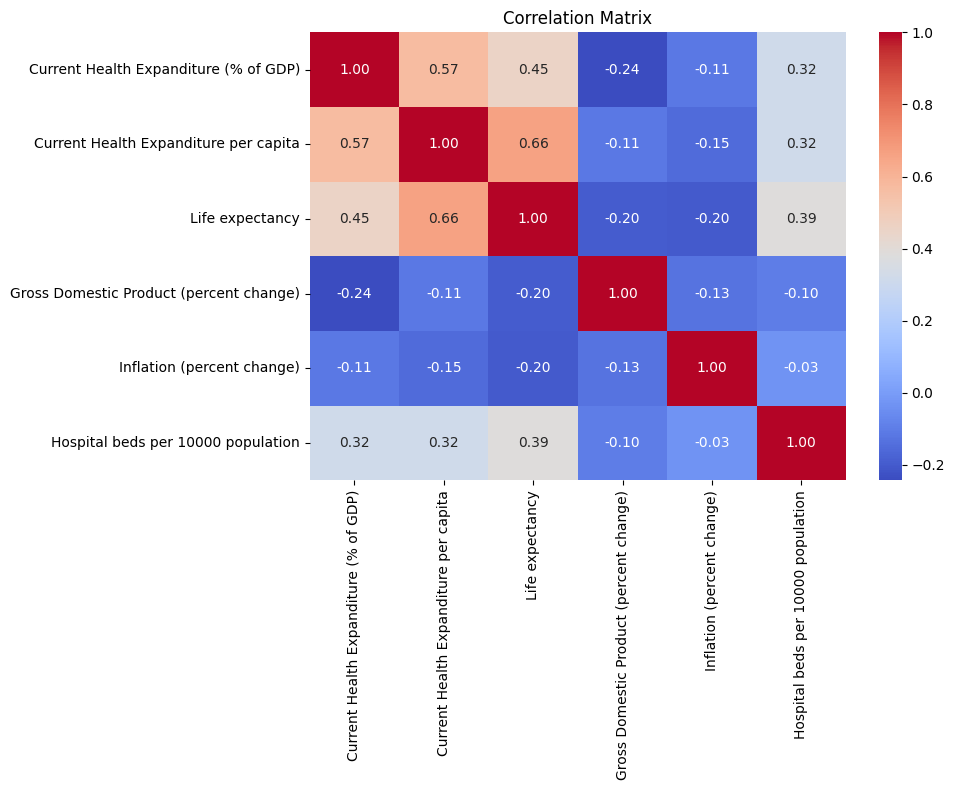

In [13]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

columns_for_correlation = [col for col in numerical_columns if col not in ['Country', 'Year']]

correlation_matrix = data[columns_for_correlation].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Regression analysis: Life expectancy vs Current Health Expenditure per capita


In [14]:
X = data['Current Health Expanditure per capita']
y = data['Life expectancy']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life expectancy   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     900.6
Date:                Fri, 19 Jul 2024   Prob (F-statistic):          5.04e-147
Time:                        14:30:14   Log-Likelihood:                 532.75
No. Observations:                1166   AIC:                            -1061.
Df Residuals:                    1164   BIC:                            -1051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.5717      0.005    104.247      0.000       0.561       0.582
Current Health Expanditure per capita     0.7473      0.025     30.009      0.000       0.698       0.796
==============================================================================
Omnibus:                      191.818   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.823
Skew:                          -1.114   Prob(JB):                     1.29e-65
Kurtosis:                       4.089   Cond. No.                         5.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

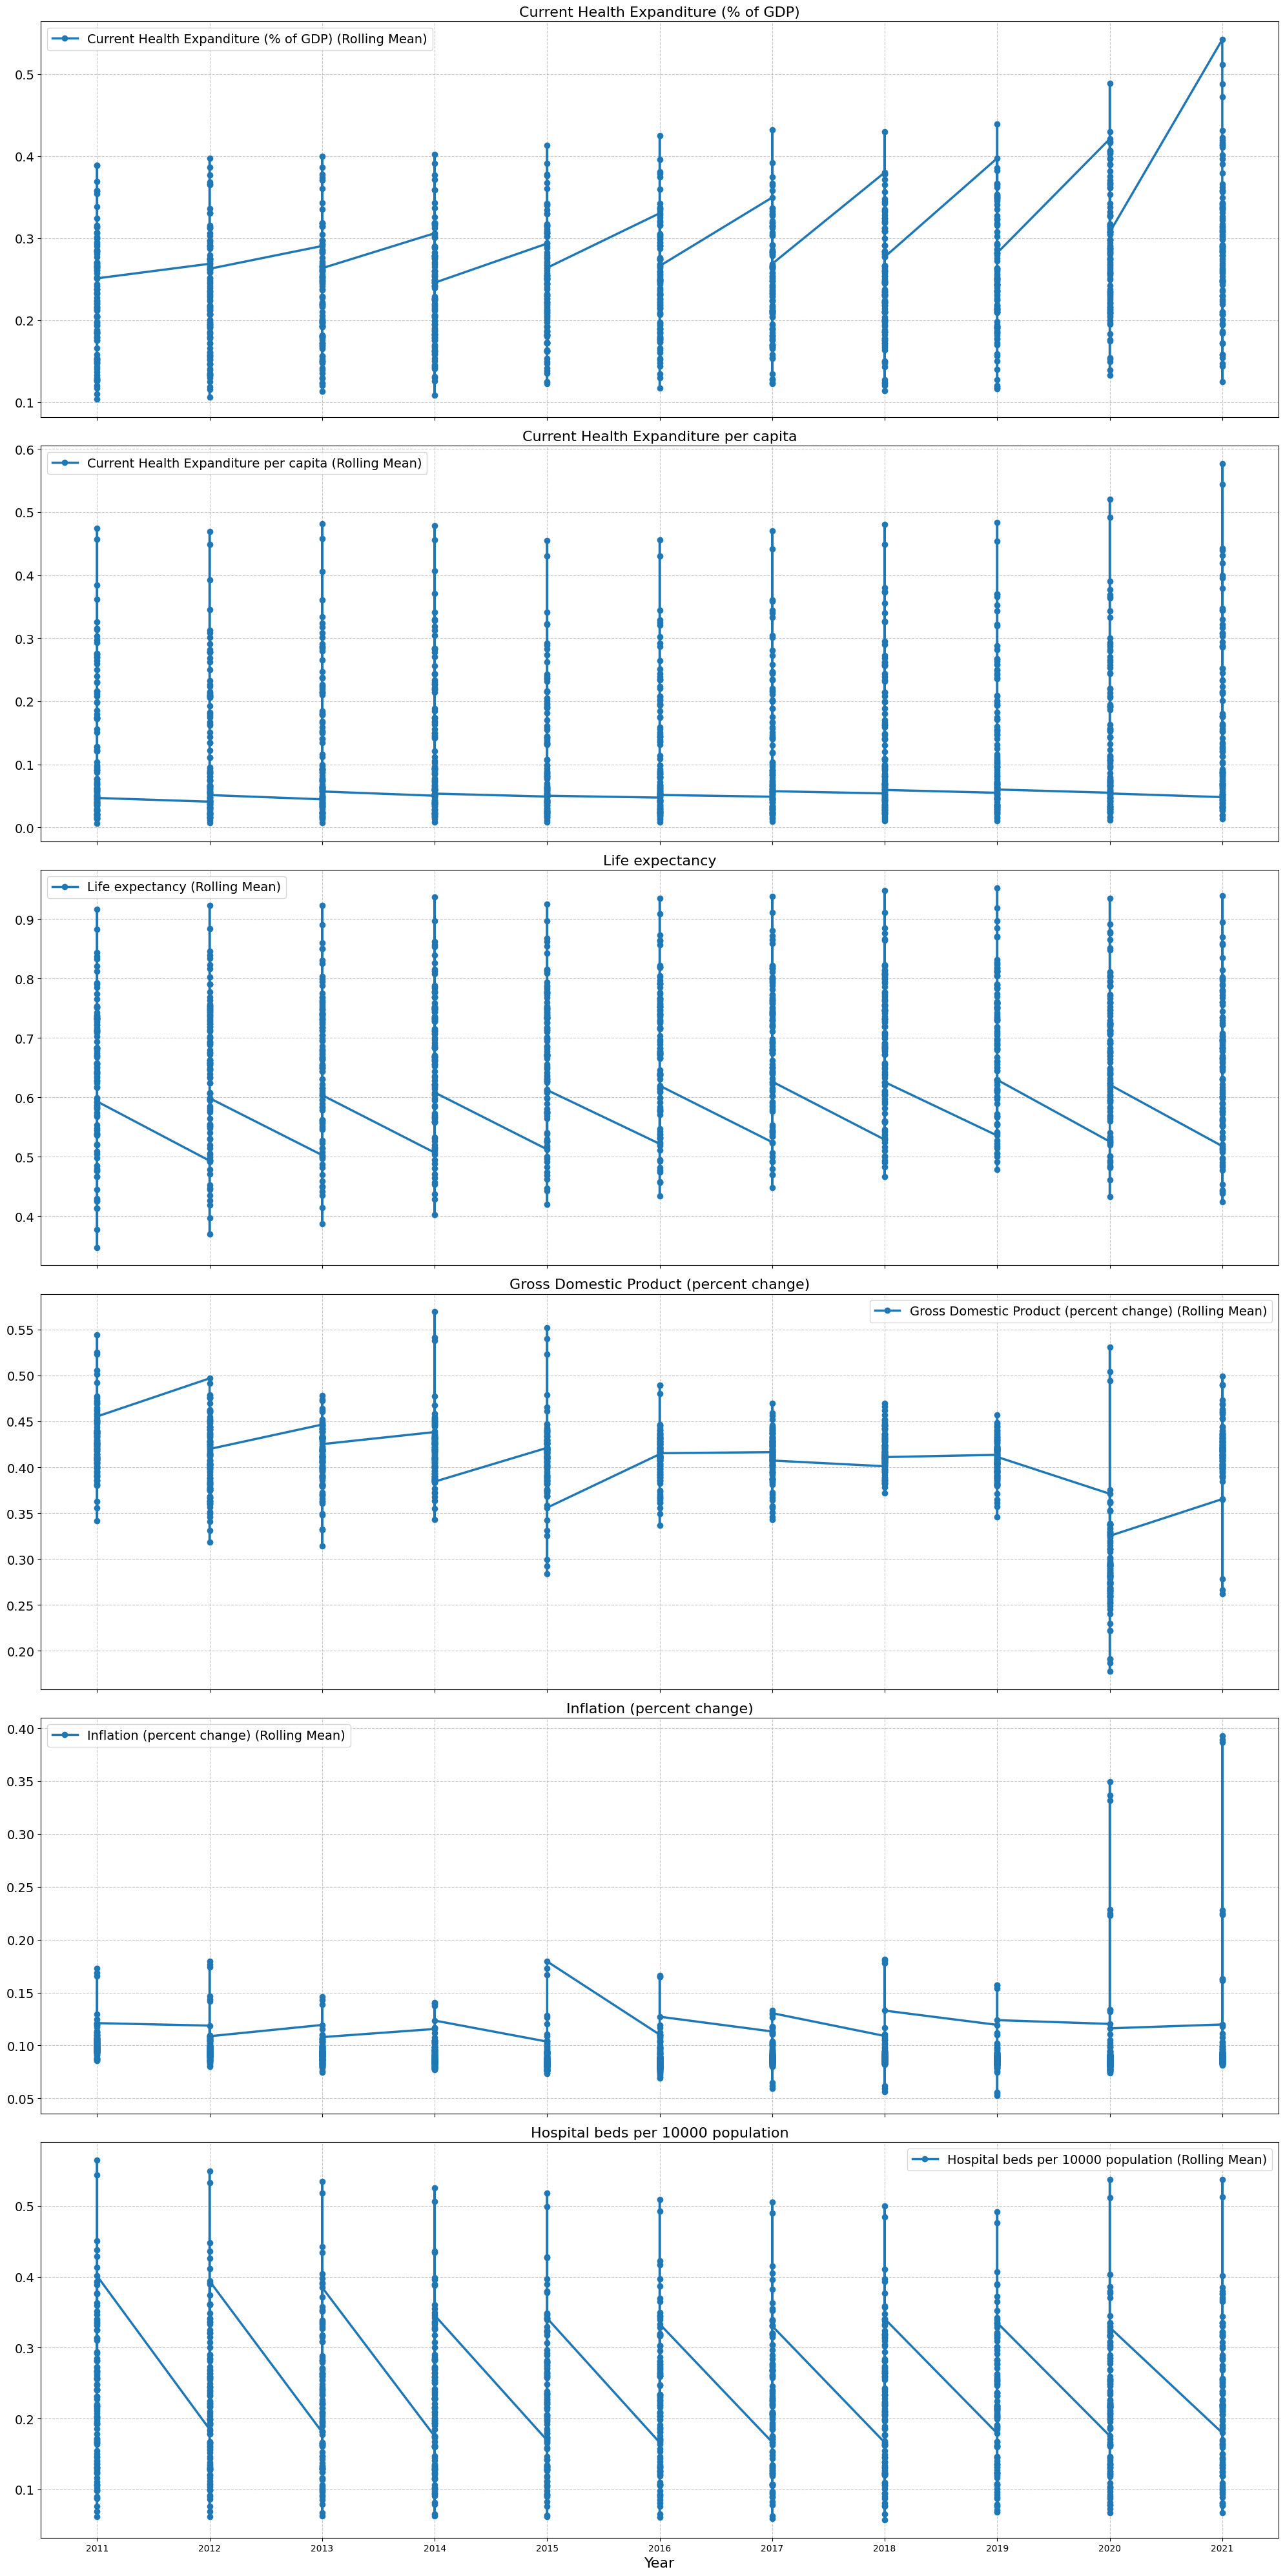

In [15]:
fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(20, 40), sharex=True)

for i, col in enumerate(numerical_columns):
    rolling_mean = data[col].rolling(window=3).mean()
    axes[i].plot(data['Year'], rolling_mean, label=f'{col} (Rolling Mean)', marker='o', linestyle='-', linewidth=2.5)
    axes[i].set_title(col, fontsize=16)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].tick_params(axis='y', labelsize=14)
    axes[i].legend(fontsize=14)

axes[-1].set_xlabel('Year', fontsize=16)
plt.tight_layout()
plt.show()


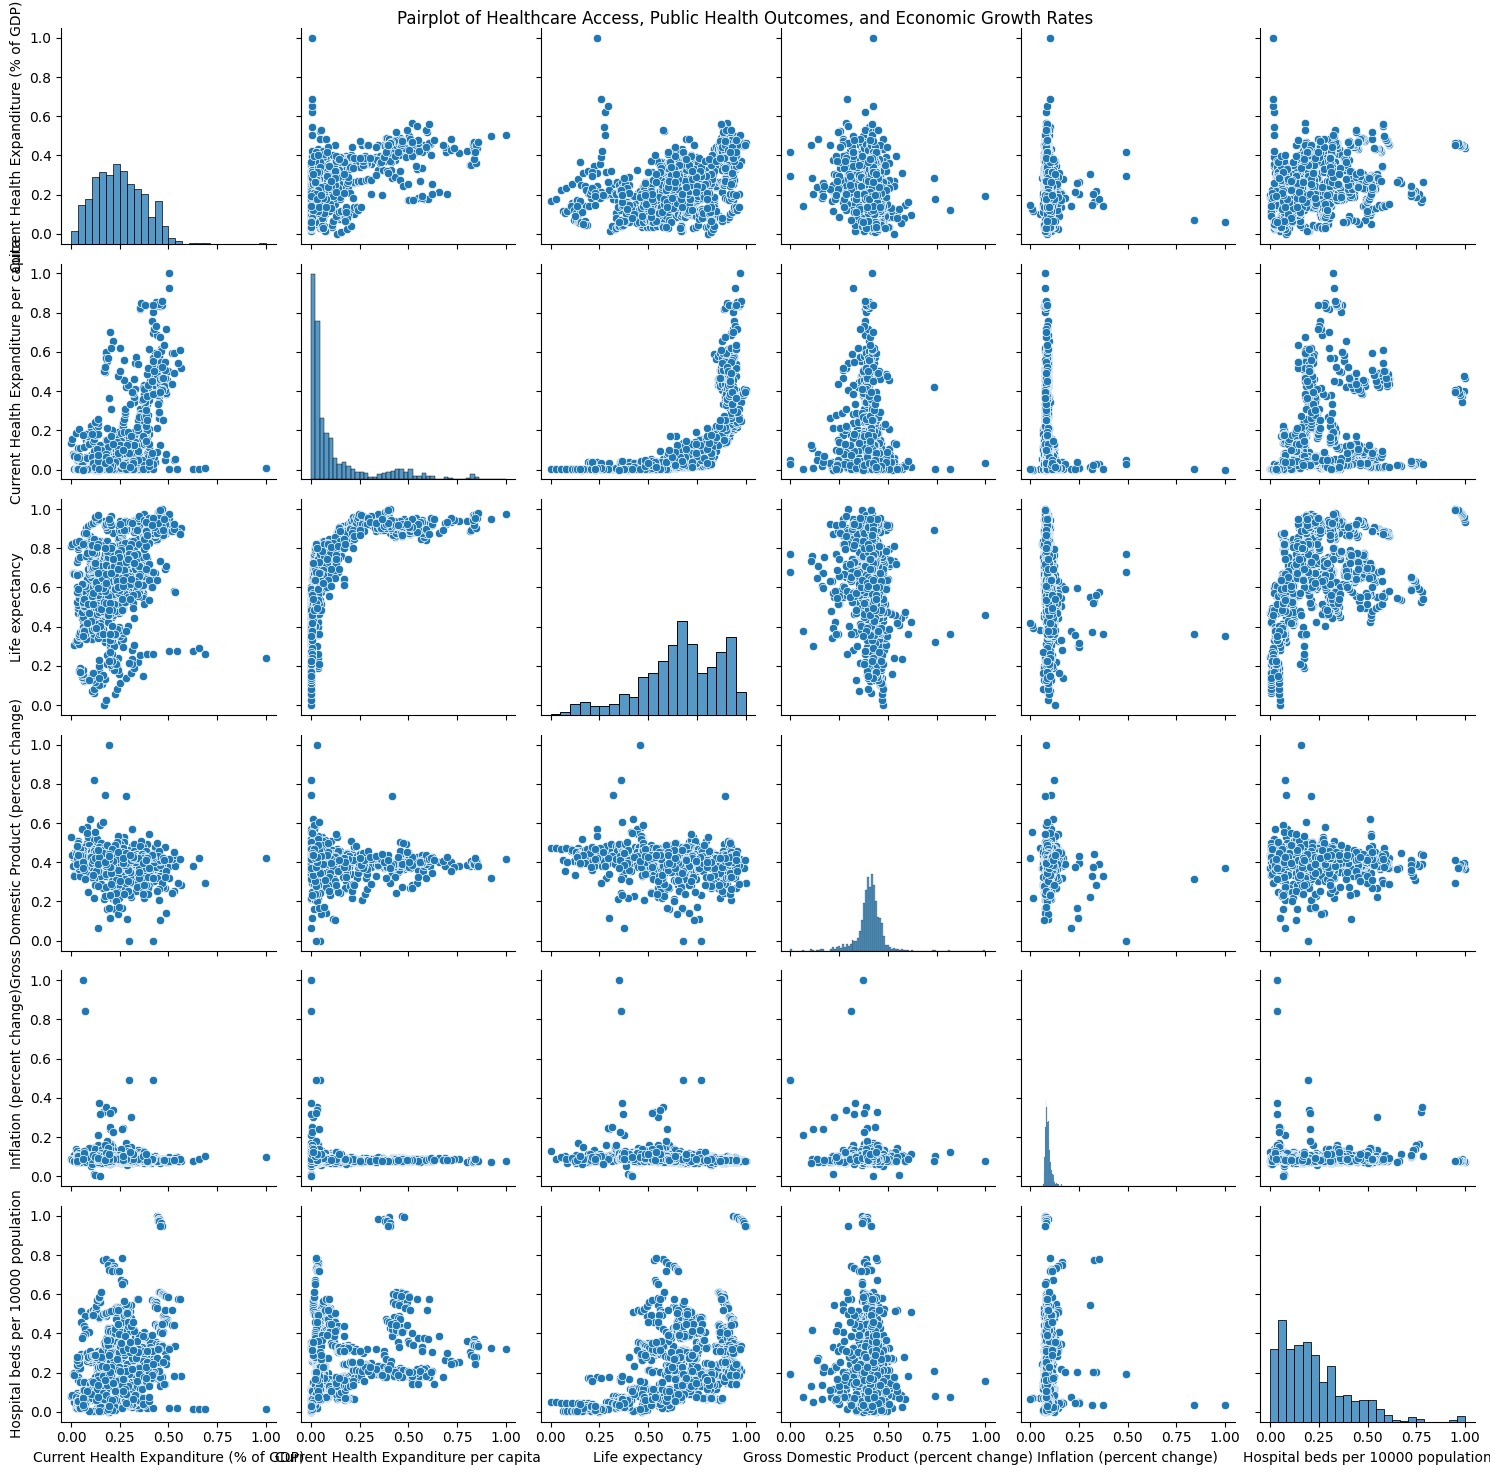

In [16]:
sns.pairplot(data[['Current Health Expanditure (% of GDP)',
       'Current Health Expanditure per capita', 'Life expectancy',
       'Gross Domestic Product (percent change)', 'Inflation (percent change)',
       'Hospital beds per 10000 population']])
plt.suptitle('Pairplot of Healthcare Access, Public Health Outcomes, and Economic Growth Rates')
plt.tight_layout()
plt.show()

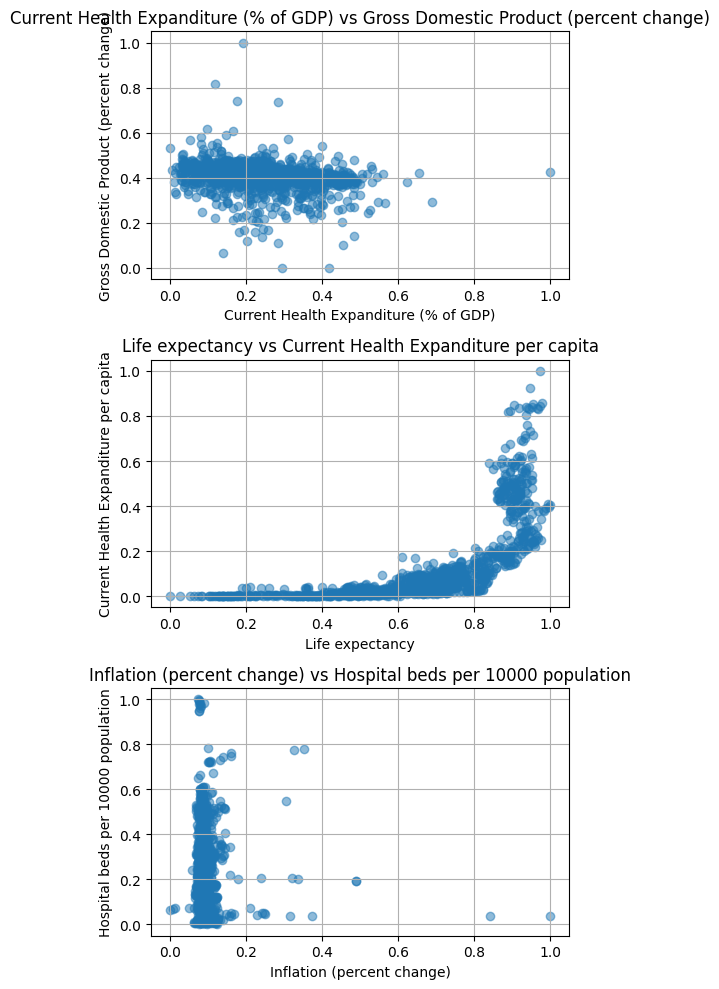

In [17]:
pairs = [
    ('Current Health Expanditure (% of GDP)', 'Gross Domestic Product (percent change)'),
    ('Life expectancy', 'Current Health Expanditure per capita'),
    ('Inflation (percent change)', 'Hospital beds per 10000 population')
]

plt.figure(figsize=(5, 10))
for i, (x_var, y_var) in enumerate(pairs, start=1):
    plt.subplot(len(pairs), 1, i)
    plt.scatter(data[x_var], data[y_var], alpha=0.5)
    plt.title(f'{x_var} vs {y_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.grid(True)

plt.tight_layout()
plt.show()

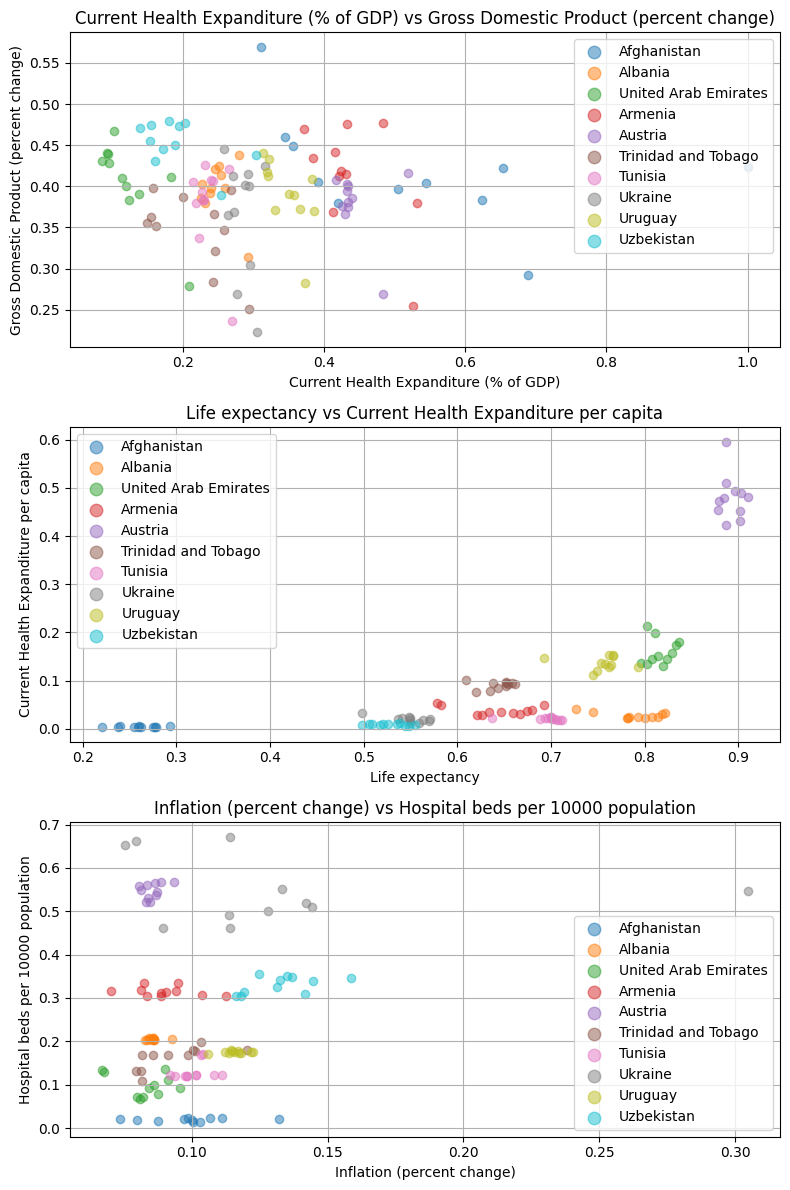

In [18]:
countries = data['Country'].unique()
plt.figure(figsize=(8, 12))
for i, (x_var, y_var) in enumerate(pairs, start=1):
    plt.subplot(len(pairs), 1, i)

    for country in countries[:5]:
        country_data = data[data['Country'] == country]
        plt.scatter(country_data[x_var], country_data[y_var], label=country, alpha=0.5)

    for country in countries[-5:]:
        country_data = data[data['Country'] == country]
        plt.scatter(country_data[x_var], country_data[y_var], label=country, alpha=0.5)

    plt.title(f'{x_var} vs {y_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.legend(markerscale=1.5)
    plt.grid(True)

plt.tight_layout()
plt.show()